In [20]:
import re
import ast
# 假设 'log_data' 是包含您所有日志信息的字符串
with open('./slurm-351256.out','r') as f:
    log_data=f.read()
# 定义正则表达式模式
# 使用非贪婪匹配 .*? 来确保匹配尽可能短的字符串
import re
# 定义正则表达式模式
# 使用非贪婪匹配 .*? 来确保匹配尽可能短的字符串
pattern = re.compile(
    r"Metrics Summary:\s*({(?:[^{}]|{[^{}]*})*})\s*.*?Output Path:\s*([^\s]+)",
    re.DOTALL
)


# 查找所有匹配的部分
matches = pattern.findall(log_data)

# 处理并输出结果
for idx, (metrics_str, output_path) in enumerate(matches, start=1):
    try:
        # 使用 ast.literal_eval 安全地将字符串字典转换为 Python 字典
        metrics = ast.literal_eval(metrics_str)
        pre_rewrite_acc = metrics.get('pre', {}).get('rewrite_acc', None)
        post_rewrite_acc = metrics.get('post', {}).get('rewrite_acc', None)
        
        print(f"匹配 {idx}:")
        print(f"Pre Rewrite Acc: {pre_rewrite_acc}")
        print(f"Post Rewrite Acc: {post_rewrite_acc}")
        print(f"Output Path: {output_path}")
        print("-" * 40)
    except (ValueError, SyntaxError) as e:
        print(f"匹配 {idx} 时解析 Metrics Summary 失败: {e}")
        print("-" * 40)

匹配 1:
Pre Rewrite Acc: 0.3333333333333333
Post Rewrite Acc: 1.0
Output Path: /home/k/kduan/szn_workspace/SafetyEvaluation_AfterEdit/safety_evaluate/llama/ROME/test_and_eval_1/part_0
----------------------------------------
匹配 2:
Pre Rewrite Acc: 0.3333333333333333
Post Rewrite Acc: 1.0
Output Path: /home/k/kduan/szn_workspace/SafetyEvaluation_AfterEdit/safety_evaluate/llama/ROME/test_and_eval_1/part_1
----------------------------------------
匹配 3:
Pre Rewrite Acc: 0.625
Post Rewrite Acc: 1.0
Output Path: /home/k/kduan/szn_workspace/SafetyEvaluation_AfterEdit/safety_evaluate/llama/ROME/test_and_eval_1/part_2
----------------------------------------
匹配 4:
Pre Rewrite Acc: 0.31285714285714283
Post Rewrite Acc: 0.9888888888888889
Output Path: /home/k/kduan/szn_workspace/SafetyEvaluation_AfterEdit/safety_evaluate/llama/ROME/test_and_eval_10/part_0
----------------------------------------
匹配 5:
Pre Rewrite Acc: 0.4216666666666666
Post Rewrite Acc: 1.0
Output Path: /home/k/kduan/szn_workspace

提取的数据：
   Method  Number of Edits    Part  Pre Rewrite Acc  Post Rewrite Acc  \
0    ROME                1  part_0         0.333333          1.000000   
1    ROME                1  part_1         0.333333          1.000000   
2    ROME                1  part_2         0.625000          1.000000   
3    ROME               10  part_0         0.312857          0.988889   
4    ROME               10  part_1         0.421667          1.000000   
5    ROME               10  part_2         0.487500          0.955000   
6    ROME               25  part_0         0.382286          0.909317   
7    ROME               25  part_1         0.364571          0.922286   
8    ROME               25  part_2         0.392556          0.925333   
9    ROME               50  part_0         0.345738          0.686635   
10   ROME               50  part_1         0.358861          0.640444   
11   ROME               50  part_2         0.360159          0.508968   
12   ROME               60  part_0         0

<Figure size 1200x800 with 0 Axes>

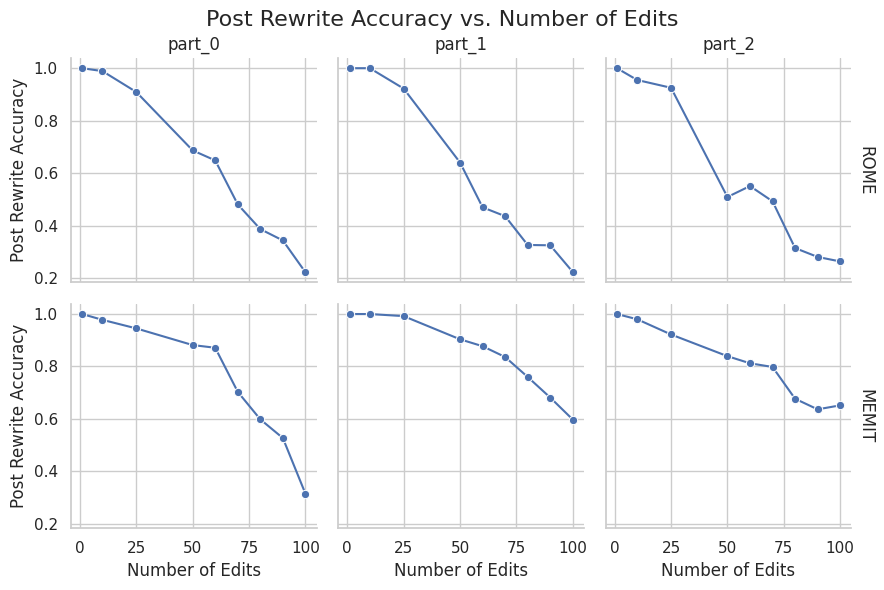


Data has been exported to 'parsed_metrics.csv'.


In [27]:
import re
import ast
import pandas as pd
import re
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
# 假设 'log_data' 是包含您所有日志信息的字符串
with open('./slurm-351256.out','r') as f:
    log_data=f.read()
# 定义正则表达式模式
# 使用非贪婪匹配 .*? 来确保匹配尽可能短的字符串
import re
# 定义正则表达式模式
# 使用非贪婪匹配 .*? 来确保匹配尽可能短的字符串
pattern = re.compile(
    r"Metrics Summary:\s*({(?:[^{}]|{[^{}]*})*})\s*.*?Output Path:\s*([^\s]+)",
    re.DOTALL
)


# 查找所有匹配的部分
matches = pattern.findall(log_data)

# 初始化列表以存储解析后的数据
data = []

# 处理并解析匹配结果
for idx, (metrics_str, output_path) in enumerate(matches, start=1):
    try:
        # 使用 ast.literal_eval 安全地将字符串字典转换为 Python 字典
        metrics = ast.literal_eval(metrics_str)
        pre_rewrite_acc = metrics.get('pre', {}).get('rewrite_acc', None)
        post_rewrite_acc = metrics.get('post', {}).get('rewrite_acc', None)
    except (ValueError, SyntaxError) as e:
        print(f"解析 Metrics Summary 失败: {e}")
        # 尝试备用解析方法
        pre_rewrite_acc = None
        post_rewrite_acc = None
        
        # 使用正则表达式单独提取 pre 和 post 的 rewrite_acc
        pre_match = re.search(r"'pre':\s*{'rewrite_acc':\s*([\d.]+)}", metrics_str)
        post_match = re.search(r"'post':\s*{'rewrite_acc':\s*([\d.]+)}", metrics_str)
        
        if pre_match:
            pre_rewrite_acc = float(pre_match.group(1))
        if post_match:
            post_rewrite_acc = float(post_match.group(1))
    
    # 从 Output Path 中提取方法、编辑次数和部件
    # 假设 Output Path 格式为 .../METHOD/test_and_eval_X/part_Y
    path_parts = output_path.split('/')
    
    # 查找方法（假设在 'mistral/METHOD/...）
    try:
        method_index = path_parts.index('ROME') if 'ROME' in path_parts else path_parts.index('MEMIT')
        method = path_parts[method_index]
    except ValueError:
        method = 'Unknown'
    
    # 查找 'test_and_eval_X'
    test_eval = next((part for part in path_parts if part.startswith('test_and_eval_')), None)
    if test_eval:
        try:
            num_edits = int(test_eval.split('_')[-1])
        except ValueError:
            num_edits = None
    else:
        num_edits = None
    
    # 查找 'part_Y'
    part = next((part for part in path_parts if part.startswith('part_')), None)
    
    # 添加到数据列表
    data.append({
        'Method': method,
        'Number of Edits': num_edits,
        'Part': part,
        'Pre Rewrite Acc': pre_rewrite_acc,
        'Post Rewrite Acc': post_rewrite_acc,
        'Output Path': output_path
    })

# 创建 DataFrame
df = pd.DataFrame(data)

# 查看数据
print("提取的数据：")
print(df)

# 检查数据是否完整
print("\n数据统计：")
print(df.describe())

# 数据清洗
# 去除缺失的编辑次数或成功率
df_clean = df.dropna(subset=['Method', 'Number of Edits', 'Part', 'Post Rewrite Acc'])

# 确保 'Number of Edits' 是整数
df_clean['Number of Edits'] = df_clean['Number of Edits'].astype(int)

# 确保 'Post Rewrite Acc' 是浮点数
df_clean['Post Rewrite Acc'] = df_clean['Post Rewrite Acc'].astype(float)

# Create DataFrame
df_clean = pd.DataFrame(data)

# Data Visualization
sns.set(style="whitegrid")

# Create a figure and FacetGrid
plt.figure(figsize=(12, 8))

# Using Seaborn's FacetGrid to categorize by Method and Part
g = sns.FacetGrid(df_clean, row="Method", col="Part", margin_titles=True, sharey=True)

# Plotting line plots in each facet
g.map_dataframe(sns.lineplot, x="Number of Edits", y="Post Rewrite Acc", marker="o")

# Adding axis labels in English
g.set_axis_labels("Number of Edits", "Post Rewrite Accuracy")

# Setting titles for each facet in English
g.set_titles(row_template='{row_name}', col_template='{col_name}')

# Adjust layout to make room for the main title
plt.subplots_adjust(top=0.9)

# Adding an overall title in English
g.fig.suptitle('Post Rewrite Accuracy vs. Number of Edits', fontsize=16)

# Display the plot
plt.show()

# Optional: Export the cleaned data to CSV for further analysis
df_clean.to_csv('parsed_metrics.csv', index=False)
print("\nData has been exported to 'parsed_metrics.csv'.")

In [22]:
! pip install pandas matplotlib seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
